In [ ]:
import os

import numpy as np
import polars as pl
from phylogenie import load_newick, get_node_depths

log_summary = pl.read_csv(
    "/Users/gmarino/BELLA-companion/log_summaries/fbd-empirical/MLP.csv"
)

change_times = (
    pl.read_csv(os.path.join("data", "change_times.csv"), has_header=False)
    .to_series()
    .to_list()
)
max_time = max(
    max(get_node_depths(tree).values())
    for tree in load_newick(os.path.join("data", "trees.nwk"))
)
time_bins = list(reversed([0.0, *change_times, max_time]))

In [6]:
plt.cm.Blues(np.linspace(0.4, 0.9, 4))

array([[0.57960784, 0.77019608, 0.87372549, 1.        ],
       [0.3313341 , 0.62206844, 0.8047674 , 1.        ],
       [0.14666667, 0.46039216, 0.71869281, 1.        ],
       [0.03137255, 0.28973472, 0.57031911, 1.        ]])

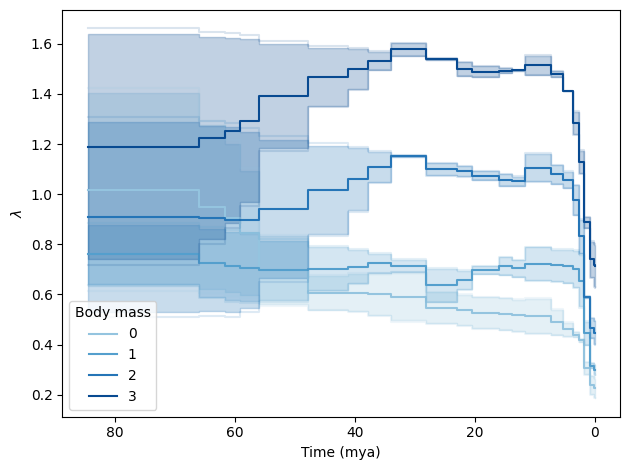

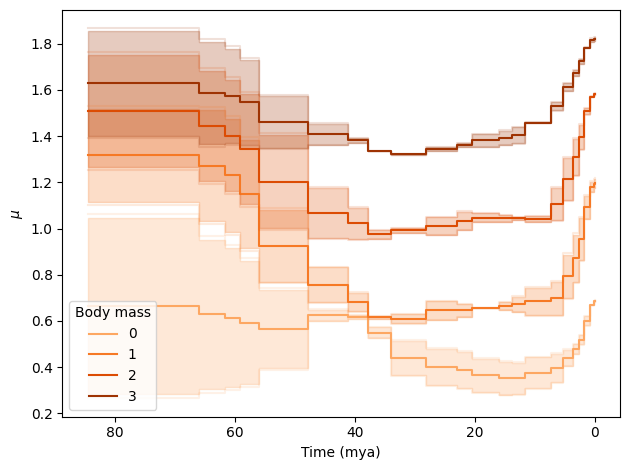

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from numpy.typing import NDArray

colors: dict[str, NDArray[np.floating]] = {
    "birth": plt.cm.Blues(np.linspace(0.4, 0.9, 4)),  # pyright: ignore
    "death": plt.cm.Oranges(np.linspace(0.4, 0.9, 4)),  # pyright: ignore
    "diversification": plt.cm.Greens(np.linspace(0.4, 0.9, 4)),  # pyright: ignore
}

for rate in ["birth", "death", "diversification"]:
    for state in range(4):
        if rate == "diversification":
            estimates = log_summary.select(
                [
                    pl.col(f"birthRateSPi{i}_{state}_median")
                    - pl.col(f"deathRateSPi{i}_{state}_median")
                    for i in range(len(change_times) + 1)
                ]
            ).to_numpy()
        else:
            estimates = log_summary.select(
                [
                    pl.col(f"{rate}RateSPi{i}_{state}_median")
                    for i in range(len(change_times) + 1)
                ]
            ).to_numpy()

        median = np.median(estimates, axis=0)
        lower = np.percentile(estimates, 2.5, axis=0)
        upper = np.percentile(estimates, 97.5, axis=0)

        color = colors[rate][state]

        plt.fill_between(  # pyright: ignore
            time_bins,
            [lower[0], *lower],
            [upper[0], *upper],
            step="pre",
            alpha=0.25,
            color=color,
        )

        for estimate in estimates:
            plt.step(  # pyright: ignore
                time_bins, [estimate[0], *estimate], color=color, alpha=0.15
            )

        plt.step(  # pyright: ignore
            time_bins, [median[0], *median], color=color, label=state
        )

    ax = plt.gca()
    ax.invert_xaxis()
    plt.legend(title="Body mass")  # pyright: ignore
    plt.xlabel("Time (mya)")  # pyright: ignore
    plt.ylabel(  # pyright: ignore
        r"$\lambda$" if rate == "birth" else r"$\mu$" if rate == "death" else r"$d$"
    )
    plt.tight_layout()
    plt.show()